# PM2.5 Prediction Model

## Quick Summary

1. Notebooks named model_1 and model_2 use date_time based time series features (year, month, day, hour, season) as regular features for forecasting: <br>
    * Model_1 uses all the date_time features (year, month, day, hour, season) and meteorological features from the original dataset, the results are not quite satisfying, best performance R2 achieved is around 0.5.
    * Model_ 2 removes the ‘iws’ (cumulated wind speed) column and only keeps the ‘ws’ (hourly wind speed) column, because the numbers in the ‘iws’ column from the original dataset contain periodically reset to zero when wind direction alters, causing undesired artifacts. Therefore, the hourly wind speed ‘ws’ was extracted from the ‘iws’ column during the data wrangling step and it makes better sense to only use the hourly wind speed data ('ws') and drop the ‘iws’ column for modeling. However, all the model performances become slightly worse after dropping the ‘iws’ feature.  
2. Notebooks named moel_3 and model_4 add additional lag features (values at previous steps): <br>
    * Model_3 introduces the lag feature of 1 hour (value from the previous one step), In this case, it’s very useful to include the values at previous time steps for predicting the value for the next step, the R2 scores after adding lag features are boosted to around 0.95. 
    * Model_4 introduces the lag feature of 24 hours (value from the 24 steps back in time, corresponding to the same hour in previous day). The lag feature of 24 hrs is not as helpful as the lag feature of 1hr, but it does help to improve model performance. The lag feature of 24 hrs boosts the R2 metrics to 0.56. 
3. Adding PCA as a preprocessing step in this case:  
    * PCA is helpful in the case of KNeighborsRegressor (kNN) model and MLPRegressor(neutral nets) model
    * PCA shows little difference in linear models (LinearRegression, Lasso and Ridge);
    * PCA shows little difference, if not actually makes it worse, in tree-based models (RandomForestRegressor and GradientBoostingRegressor).
4.	Model comparison:
    * Ranking of feature importance is only possible without using PCA for selective algorithms (LinearRegression, Lasso, Ridge, RandomForestRegressor, GradientBoostingRegressor). For KNeighborsRegressor and MLPRegressor, ranking of feature importance seems impossible (fitting results harder to interpret) 
    * Model performance: Neural network-based algorithms (MLPRegressor) and Tree-based algorithms (RandomForestRegressor and GradientBoostingRegressor) in general give the best performance (R2_score and mean_squared_error), followed by KNeighborsRegressor, followed by linear models (LinearRegression, Lasso and Ridge). But GradientBoostingRegressor takes longer to train because it only works in sequential order; MLPRegressor is harder to design hidden layer structures. 

In [1]:
# import relevant module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler #, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import pm_clean from 'pm_clean.csv' file and parse the strings in 'date_time' column into DateTime objects

pm_clean = pd.read_csv('pm_clean.csv',index_col=0, parse_dates=['date_time'])
print(pm_clean.head(1))
print(pm_clean.info())

   year  month  day  hour  season  dewp  humi    pres  temp cbwd   iws  \
0  2010      1    1    23       4 -17.0  41.0  1020.0  -5.0   CV  0.89   

   precipitation  iprec     city  pm_average           date_time    ws  
0            0.0    0.0  beijing       129.0 2010-01-01 23:00:00  0.89  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 168895 entries, 0 to 168894
Data columns (total 17 columns):
year             168895 non-null int64
month            168895 non-null int64
day              168895 non-null int64
hour             168895 non-null int64
season           168895 non-null int64
dewp             168895 non-null float64
humi             168895 non-null float64
pres             168895 non-null float64
temp             168895 non-null float64
cbwd             168895 non-null object
iws              168895 non-null float64
precipitation    168895 non-null float64
iprec            168895 non-null float64
city             168895 non-null object
pm_average       168895 non-null

In [3]:
# use a subset of one city (city Beijing) to explore for now
bj = pm_clean[pm_clean['city'] == 'beijing']

# drop target column 'pm_average' and columns containing irrelevant or duplicated information 'city','date_time' and 'iws'
X = bj.drop(['pm_average','city','date_time','iws'], axis=1)
X = pd.get_dummies(X, drop_first=True)
print(X.info())
print(X.describe())
y = bj['pm_average']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49854 entries, 0 to 49853
Data columns (total 13 columns):
year             49854 non-null int64
month            49854 non-null int64
day              49854 non-null int64
hour             49854 non-null int64
season           49854 non-null int64
dewp             49854 non-null float64
humi             49854 non-null float64
pres             49854 non-null float64
temp             49854 non-null float64
cbwd             49854 non-null object
precipitation    49854 non-null float64
iprec            49854 non-null float64
ws               49854 non-null float64
dtypes: float64(7), int64(5), object(1)
memory usage: 5.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49854 entries, 0 to 49853
Data columns (total 15 columns):
year             49854 non-null int64
month            49854 non-null int64
day              49854 non-null int64
hour             49854 non-null int64
season           49854 non-null int64
dewp            

In [4]:
# train test split by year, using data of year 2010-2014 as training set and data of year 2015 as test set

X_train = X[X['year'] != 2015]
y_train = y[X['year'] != 2015]
print(len(X_train), len(y_train))

X_test = X[X['year'] == 2015]
y_test = y[X['year'] == 2015]
print(len(X_test),len(y_test))

41892 41892
7962 7962


In [5]:
# initialize a score table

index = ['LinearRegression','Lasso','Ridge','RandomForestRegressor','GradientBoostingRegressor','KNeighborsRegressor','MLPRegressor']
score_table = pd.DataFrame(index = index, columns= ['r2_train','r2_test','mse_train','mse_test'])
print(score_table)

                          r2_train r2_test mse_train mse_test
LinearRegression               NaN     NaN       NaN      NaN
Lasso                          NaN     NaN       NaN      NaN
Ridge                          NaN     NaN       NaN      NaN
RandomForestRegressor          NaN     NaN       NaN      NaN
GradientBoostingRegressor      NaN     NaN       NaN      NaN
KNeighborsRegressor            NaN     NaN       NaN      NaN
MLPRegressor                   NaN     NaN       NaN      NaN


### LinearRegression model

In [6]:
# explore with LinearRegression model using default parameters

scaler = StandardScaler()
linreg = LinearRegression()
linreg_1 = Pipeline([('scaler', scaler),('linreg',linreg)])
linreg_1.fit(X_train, y_train)
y_pred_train = linreg_1.predict(X_train)
y_pred_test = linreg_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(linreg_1.named_steps.linreg.coef_, linreg_1.named_steps.linreg.intercept_)

0.3137785400963785 0.2724709156226759
5595.170341492227 6022.309951873517
[ -1.78945549  -5.34414874   6.49873313  10.18376173   8.05912359
 -41.44385034  55.76379535 -18.18717133   5.93845629  -1.63247959
  -7.19835636 -12.79767249  -6.96053469 -12.82200853   4.00564336] 97.14399129507635


In [7]:
# adding PCA as a preprocessing step to decorrelate features

pca = PCA()
scaler = StandardScaler()
linreg = LinearRegression()
linreg_2 = Pipeline([('pca', pca),('scaler', scaler),('linreg',linreg)])
linreg_2.fit(X_train, y_train)
y_pred_train = linreg_2.predict(X_train)
y_pred_test = linreg_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(linreg_2.named_steps.linreg.coef_, linreg_2.named_steps.linreg.intercept_)
# add scores to the score table
score_table.loc['LinearRegression',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.3137785400963784 0.2724709156226762
5595.170341492228 6022.309951873514
[-35.55168939 -19.8996859    6.37311463 -11.75536264  10.98694693
 -12.23021872  -3.9069172  -14.15254745   3.46897006   3.71460416
   5.3039814   -1.60449857  12.03534152  -1.84492444   5.39031201] 97.14399129507623


Adding PCA to decorrelate features doesn't affect the model performance at all. In fact, the performance also remains the same without the StandardScaler.

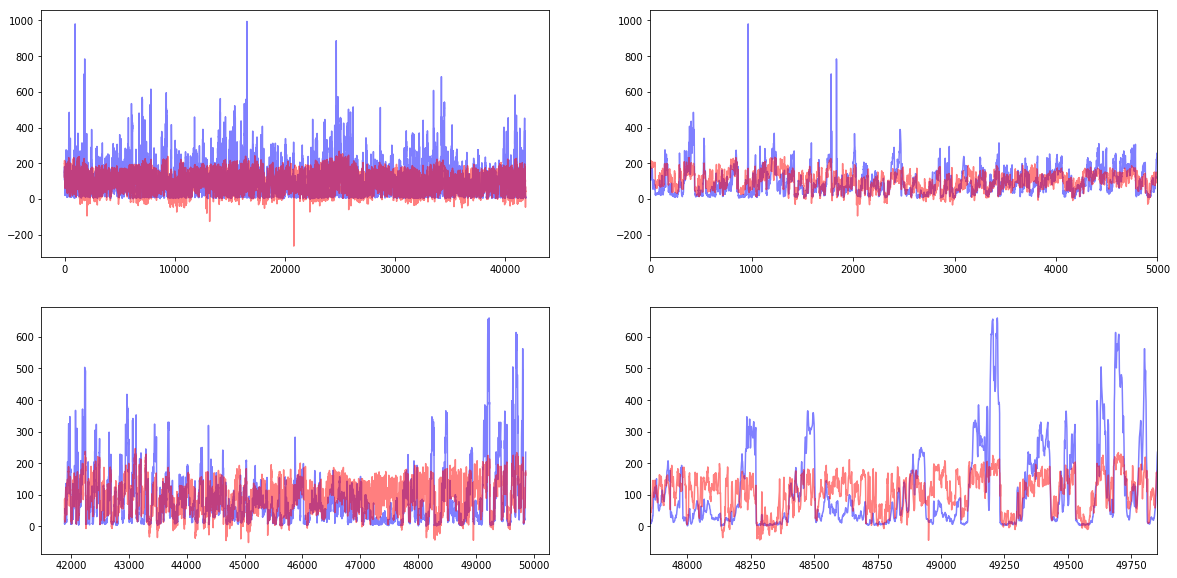

In [8]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

The linear regression model seems to catch some of the periodic trends in both the training and the testing sets, but two major problems are noticed: 
1) the model fails to catch and predict the extremely high PM2.5 values
2) negative PM2.5 values are predicted by the model, whereas in reality, the values should always be non-negative.

### Lasso model

In [9]:
# explore with LASSO model using default parameters

scaler = StandardScaler()
lasso= Lasso()
lasso_1 = Pipeline([('scaler', scaler),('lasso',lasso)])
lasso_1.fit(X_train, y_train)
y_pred_train = lasso_1.predict(X_train)
y_pred_test = lasso_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(lasso_1.named_steps.lasso.coef_, lasso_1.named_steps.lasso.intercept_)

0.30680832018984017 0.24850758265080986
5652.0026762026855 6220.6726314357265
[ -0.56558617  -4.72195057   5.38428276   8.90745426   5.62693485
  -0.9983615   34.14835565 -11.44821822 -19.39174801  -0.94531289
  -6.08142594 -11.48660847  -5.86001177 -11.53240027   2.92953069] 97.14399129507629


In [10]:
# adding PCA as a preprocessing step to decorrelate features

lasso_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('lasso', Lasso())])
lasso_2.fit(X_train, y_train)
y_pred_train = lasso_2.predict(X_train)
y_pred_test = lasso_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(lasso_2.named_steps.lasso.coef_, lasso_2.named_steps.lasso.intercept_)

0.3119388602885588 0.2659532940900261
5610.170341492228 6076.26124792681
[-34.55168939 -18.8996859    5.37311463 -10.75536264   9.98694693
 -11.23021872  -2.9069172  -13.15254745   2.46897006   2.71460416
   4.3039814   -0.60449857  11.03534152  -0.84492444   4.39031201] 97.14399129507623


In [11]:
# grid search of parameter alpha to improve lasso model

parameters = {'lasso__alpha': np.arange(0.3,1,0.05)}
lasso_cv = GridSearchCV(lasso_2, parameters, scoring='r2',cv=3)
lasso_cv.fit(X_train, y_train)
print(lasso_cv.best_params_)
print(lasso_cv.best_score_)

{'lasso__alpha': 0.6499999999999999}
0.27939236922669713


In [12]:
# update model with best parameters

lasso_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('lasso', Lasso(alpha=0.65))])
lasso_3.fit(X_train, y_train)
y_pred_train = lasso_3.predict(X_train)
y_pred_test = lasso_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(lasso_3.named_steps.lasso.coef_, lasso_3.named_steps.lasso.intercept_)

# add scores to the score table
score_table.loc['Lasso',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.3130012753775746 0.26867328105075594
5601.507841492227 6053.745853155218
[-34.90168939 -19.2496859    5.72311463 -11.10536264  10.33694693
 -11.58021872  -3.2569172  -13.50254745   2.81897006   3.06460416
   4.6539814   -0.95449857  11.38534152  -1.19492444   4.74031201] 97.14399129507623


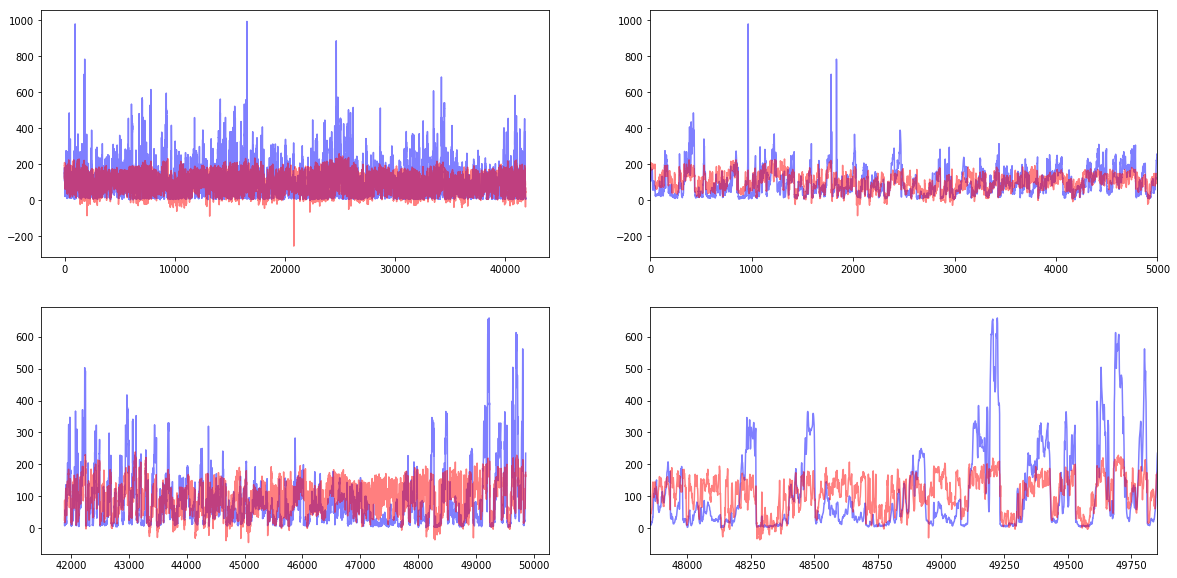

In [13]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### Ridge model

In [14]:
# explore with Ridge model using default parameters

ridge_1 = Pipeline([('scaler', StandardScaler()),('ridge',Ridge())])
ridge_1.fit(X_train, y_train)
y_pred_train = ridge_1.predict(X_train)
y_pred_test = ridge_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(ridge_1.named_steps.ridge.coef_, ridge_1.named_steps.ridge.intercept_)

0.31377852050745414 0.2724617324524212
5595.170501212339 6022.3859679377565
[ -1.78871612  -5.34390157   6.49846713  10.18335437   8.05711555
 -41.35766326  55.7162738  -18.18601693   5.87224051  -1.63243246
  -7.19737413 -12.79594387  -6.96028289 -12.82139046   4.00431878] 97.14399129507635


In [15]:
# adding PCA as a preprocessing step to decorrelate features

ridge_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('ridge', Ridge())])
ridge_2.fit(X_train, y_train)
y_pred_train = ridge_2.predict(X_train)
y_pred_test = ridge_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(ridge_2.named_steps.ridge.coef_, ridge_2.named_steps.ridge.intercept_)

0.3137785399175895 0.2724712637466672
5595.170342949999 6022.307070187242
[-35.55084076 -19.89921089   6.3729625  -11.75508203  10.98668467
 -12.22992678  -3.90682394 -14.15220962   3.46888726   3.71451549
   5.3038548   -1.60446027  12.03505423  -1.8448804    5.39018335] 97.14399129507623


In [16]:
# grid search of parameter alpha to improve Ridge model

parameters = {'ridge__alpha': np.arange(1,2500, 50)}
ridge_cv = GridSearchCV(ridge_2, parameters, scoring='r2',cv=3)
ridge_cv.fit(X_train, y_train)
print(ridge_cv.best_params_)
print(ridge_cv.best_score_)

{'ridge__alpha': 1801}
0.27913507867648973


In [17]:
# update model with best parameters

ridge_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('ridge', Ridge(alpha=1801))])
ridge_3.fit(X_train, y_train)
y_pred_train = ridge_3.predict(X_train)
y_pred_test = ridge_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(ridge_3.named_steps.ridge.coef_, ridge_3.named_steps.ridge.intercept_)

# add scores to the score table
score_table.loc['Ridge',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.3132454176919047 0.27255046826252705
5599.517204480621 6021.651434344855
[-34.08626947 -19.07943245   6.11041856 -11.27081344  10.53407138
 -11.72609623  -3.74587635 -13.56918769   3.32598114   3.56149034
   5.08535438  -1.53836208  11.53925176  -1.76887773   5.16812649] 97.14399129507623


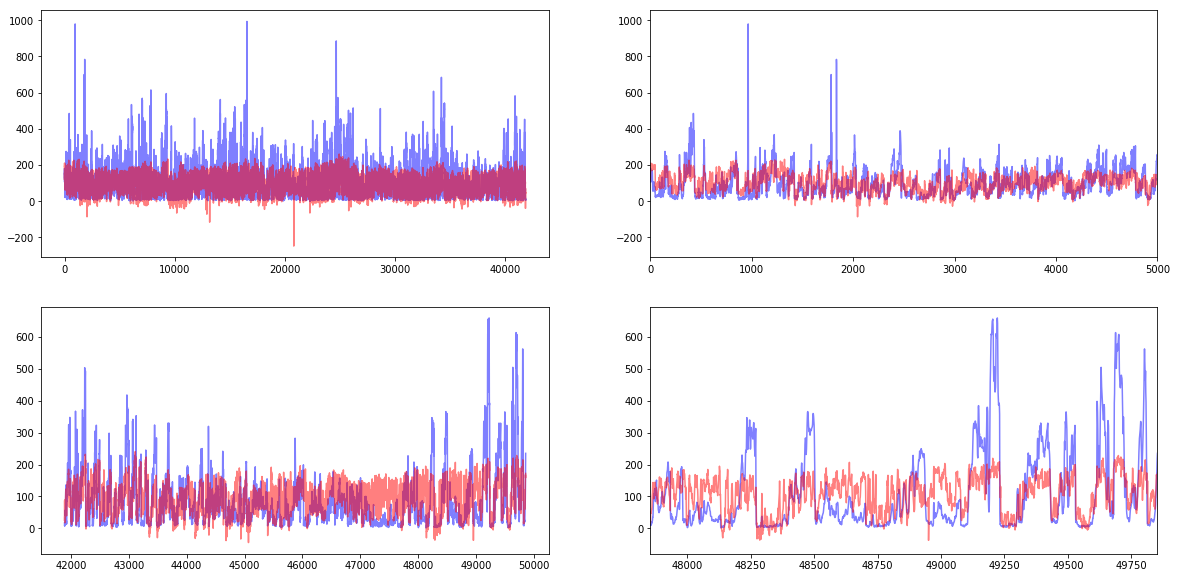

In [18]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### RandomForestRegressor model

In [19]:
# explore with RandomForestRegressor model using default parameters

rfr_1 = Pipeline([('scaler', StandardScaler()),('rfr',RandomForestRegressor())])
rfr_1.fit(X_train, y_train)
y_pred_train = rfr_1.predict(X_train)
y_pred_test = rfr_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(rfr_1.named_steps.rfr.n_features_)
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': rfr_1.named_steps.rfr.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

0.9708751471732759 0.4253301699943772
237.47218974950138 4756.977982875254
15
          feature  importance
6            humi    0.219022
5            dewp    0.152622
2             day    0.147062
7            pres    0.098508
1           month    0.089924
0            year    0.057912
3            hour    0.056174
4          season    0.052366
11             ws    0.036062
8            temp    0.034537
13        cbwd_NW    0.032547
12        cbwd_NE    0.011749
14        cbwd_SE    0.005795
10          iprec    0.004129
9   precipitation    0.001590


In [20]:
# adding PCA as a preprocessing step to decorrelate features

rfr_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('rfr',RandomForestRegressor(n_jobs=2))])
rfr_2.fit(X_train, y_train)
y_pred_train = rfr_2.predict(X_train)
y_pred_test = rfr_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(rfr_2.named_steps.rfr.n_features_)

0.9456577183301892 0.3635125039377982
443.0848355145375 5268.689684150758
15
          feature  importance
0            year    0.201549
2             day    0.099332
1           month    0.098551
6            humi    0.087213
5            dewp    0.083942
10          iprec    0.073965
9   precipitation    0.055583
3            hour    0.048726
12        cbwd_NE    0.043639
7            pres    0.042626
8            temp    0.038875
4          season    0.037369
11             ws    0.035399
14        cbwd_SE    0.027453
13        cbwd_NW    0.025778


In comparison to linear models, RandomForestRegressor performs better at catching extreme values and eliminating negative prediction values. 
The score reveals that the RandomForestRegressor with default parameters suffer significantly from overfitting, parameter optimization is very important. 

In [21]:
# grid search of parameter n_estimators and max_features to improve RandomForestRegressor model

parameters = {'rfr__n_estimators': np.arange(20,180,10), 'rfr__max_features':['auto','sqrt','log2']}
rfr_cv = GridSearchCV(rfr_2, parameters, scoring='r2',cv=3)
rfr_cv.fit(X_train, y_train)
print(rfr_cv.best_params_)
print(rfr_cv.best_score_)

{'rfr__max_features': 'log2', 'rfr__n_estimators': 70}
0.3704689968636841


In [22]:
# update model with best parameters

rfr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('rfr', RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=2))])
rfr_3.fit(X_train, y_train)
y_pred_train = rfr_3.predict(X_train)
y_pred_test = rfr_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(rfr_3.named_steps.rfr.n_features_)

# add scores to the score table
score_table.loc['RandomForestRegressor',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.9587170424264173 0.4363393847658268
336.6044248415568 4665.846363392085
15
          feature  importance
0            year    0.142430
5            dewp    0.099528
6            humi    0.087279
1           month    0.082832
2             day    0.067482
10          iprec    0.065632
7            pres    0.056630
12        cbwd_NE    0.055885
11             ws    0.053666
9   precipitation    0.050999
3            hour    0.050500
8            temp    0.050355
4          season    0.049167
14        cbwd_SE    0.046460
13        cbwd_NW    0.041155


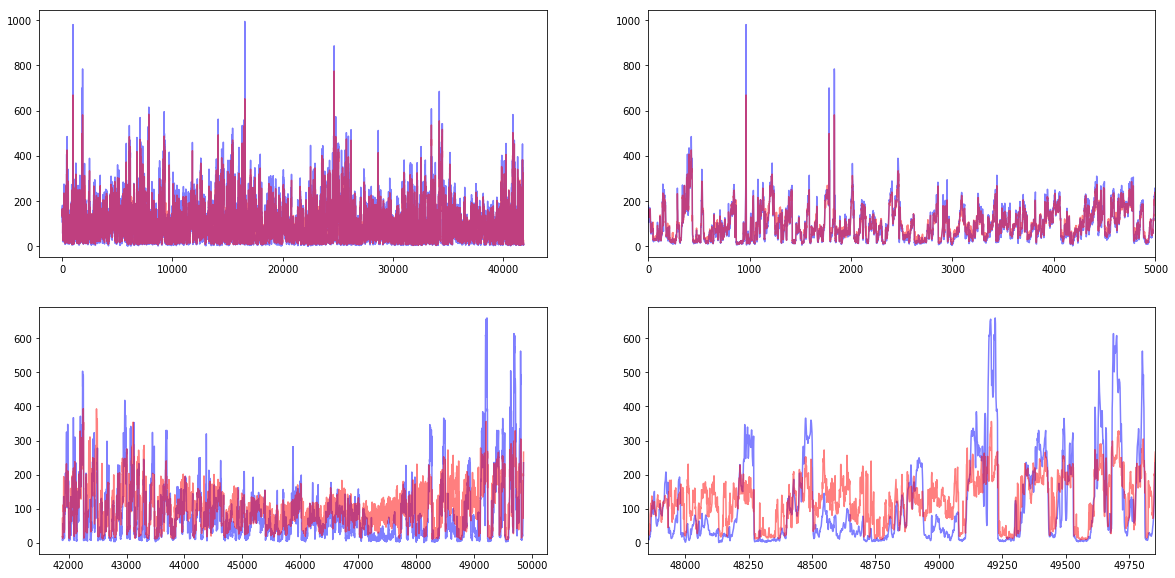

In [23]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### GradientBoostingRegressor model

In [24]:
# explore with GradientBoostingRegressor model using default parameters

gbr_1 = Pipeline([('scaler', StandardScaler()),('gbr',GradientBoostingRegressor())])
gbr_1.fit(X_train, y_train)
y_pred_train = gbr_1.predict(X_train)
y_pred_test = gbr_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(gbr_1.named_steps.gbr.train_score_)
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': gbr_1.named_steps.gbr.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

0.5484560083269563 0.5026727484748179
3681.705830713695 4116.754808175692
[7696.45102366 7318.82205595 7008.59676316 6742.86231718 6522.12230948
 6341.33207199 6182.24403579 6032.97564285 5905.4159582  5790.86200895
 5686.96438389 5600.71825829 5524.5948766  5447.26897348 5381.53692917
 5328.07761196 5273.70554283 5217.85078538 5137.8259268  5100.70142643
 5060.36786209 5019.81448407 4965.21007433 4920.69670754 4866.9474439
 4843.32841579 4811.14140548 4769.05092667 4750.28099578 4710.35327337
 4680.91463202 4649.06699298 4616.37178228 4563.13025233 4542.66852648
 4516.85190416 4502.03262651 4481.14451168 4439.76750986 4416.37990442
 4390.99358718 4379.99134339 4362.08927657 4337.68184877 4305.01264128
 4291.46785778 4278.52810079 4265.49308233 4248.6424153  4235.72728512
 4223.74243282 4206.73180737 4187.95185996 4177.38968887 4165.2455999
 4147.96726622 4137.96809424 4124.7458377  4114.55319632 4091.47599734
 4081.94317927 4074.30611088 4060.5960308  4046.08034615 4037.77512939
 4028

In [25]:
# adding PCA as a preprocessing step to decorrelate features

gbr_2 = Pipeline([('pca',PCA()),('scaler', StandardScaler()),('gbr',GradientBoostingRegressor())])
gbr_2.fit(X_train, y_train)
y_pred_train = gbr_2.predict(X_train)
y_pred_test = gbr_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(gbr_2.named_steps.gbr.train_score_)

0.48994844458602005 0.4340292598032125
4158.752680053308 4684.969019587102
[7732.64207952 7379.72052525 7094.46405035 6845.68438403 6623.75234242
 6446.93899544 6289.47483267 6149.8372862  6022.28154409 5912.01368225
 5813.49613771 5723.28510963 5644.86736114 5564.08008563 5499.48393654
 5438.39184032 5379.63009354 5327.04928062 5284.41535595 5241.58479796
 5193.79569461 5157.13981393 5128.59514923 5092.5141233  5050.26261345
 5017.45761797 4986.37611156 4962.35590307 4937.08455469 4907.00920327
 4889.16168544 4868.25973117 4848.06981049 4828.65606705 4814.10876907
 4800.29120845 4779.10039475 4758.22979452 4741.09001141 4720.8121593
 4703.46319015 4691.77956241 4680.70897348 4670.07964851 4655.96160115
 4639.22488448 4626.85154602 4615.93368284 4600.49263381 4589.64475734
 4569.6777232  4555.0455586  4546.91065056 4535.68044833 4526.19750785
 4516.76382986 4498.83083012 4493.4234099  4482.09254273 4476.96248967
 4461.67848195 4454.3803441  4437.23355939 4430.16092127 4420.2725039
 440

In [28]:
# grid search of parameter n_estimators, max_features, max_depth, learning_rate to improve GradientBoostingRegressor model

parameters = {'gbr__n_estimators': np.arange(10,100,20), 'gbr__learning_rate': [0.01, 0.05, 0.1, 0.15],'gbr__max_features':['auto','sqrt','log2'],'gbr__max_depth': np.arange(5,12,2)}
gbr_cv = GridSearchCV(gbr_2, parameters, scoring='r2',cv=3)
gbr_cv.fit(X_train, y_train)
print(gbr_cv.best_params_)
print(gbr_cv.best_score_)

{'gbr__learning_rate': 0.05, 'gbr__max_depth': 5, 'gbr__max_features': 'log2', 'gbr__n_estimators': 90}
0.3732311699006885


In [44]:
# update model with best parameters

gbr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),
                  ('gbr', GradientBoostingRegressor(n_estimators=90, learning_rate=0.05, max_features='log2', max_depth=5))])
gbr_3.fit(X_train, y_train)
y_pred_train = gbr_3.predict(X_train)
y_pred_test = gbr_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(gbr_3.named_steps.gbr.train_score_)

# add scores to the score table
score_table.loc['GradientBoostingRegressor',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.5179541306495594 0.42076770754213233
3930.405720344608 4794.744944528368
[7903.95928509 7707.06552261 7557.90161819 7379.48356753 7224.4489479
 7078.19465565 6916.08698832 6777.10422759 6651.15893382 6532.97369985
 6409.61646739 6290.61148707 6197.43807421 6088.85966339 5988.2604265
 5902.41537799 5821.55190299 5749.24862574 5682.1528731  5600.99921147
 5530.77622467 5464.07599356 5403.78391661 5348.91070324 5300.81119257
 5251.66878979 5194.68060429 5144.71576953 5109.46940715 5068.32840691
 5028.22499248 5002.95437831 4968.64851811 4932.50074042 4887.59596212
 4857.25866698 4823.61127332 4793.41476547 4763.34287276 4738.96937816
 4713.77691515 4690.18685445 4660.62388225 4637.11030323 4616.68956325
 4589.63791128 4562.46602968 4549.03298501 4528.62195058 4506.99384971
 4483.91657944 4467.80194908 4448.84634148 4433.66410074 4416.91824992
 4391.13309469 4373.7420845  4356.49686408 4329.43466088 4312.36781649
 4294.75365535 4276.55661828 4252.60855487 4239.03105159 4214.56980755
 420

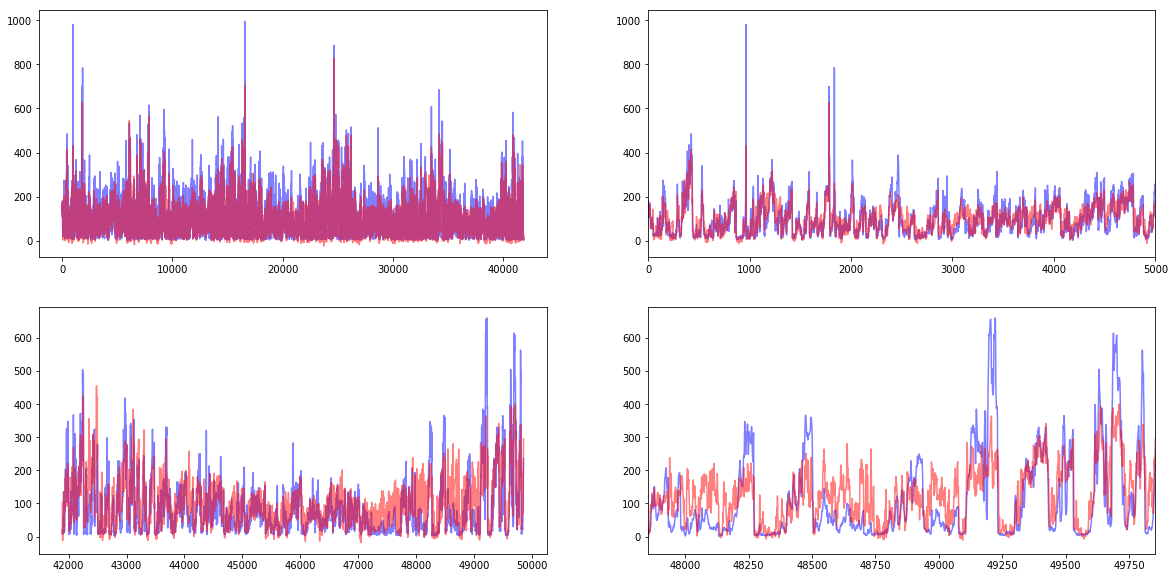

In [30]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### KNeighborsRegressor model

In [31]:
# explore with KNeighborsRegressor model using default parameters

knr_1 = Pipeline([('scaler', StandardScaler()),('knr',KNeighborsRegressor(n_jobs=2))])
knr_1.fit(X_train, y_train)
y_pred_train = knr_1.predict(X_train)
y_pred_test = knr_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)

0.8165825741083778 0.24858312739202248
1495.510999620718 6220.04729032348


In [32]:
# adding PCA as a preprocessing step to decorrelate features

knr_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('knr',KNeighborsRegressor(n_jobs=2))])
knr_2.fit(X_train, y_train)
y_pred_train = knr_2.predict(X_train)
y_pred_test = knr_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)

0.7957805238552861 0.2690239557044075
1665.1224463899232 6050.843053113399


In [33]:
# grid search of parameters n_neighbors, weights to improve KNeighborsRegressor model

parameters = {'knr__n_neighbors': np.arange(1,100,10),'knr__weights':['distance','uniform']}
knr_cv = GridSearchCV(knr_2, parameters, scoring='r2',cv=3)
knr_cv.fit(X_train, y_train)
print(knr_cv.best_params_)
print(knr_cv.best_score_)

{'knr__n_neighbors': 71, 'knr__weights': 'distance'}
0.33110609349573267


In [34]:
# update model with best parameters
knr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('knr',KNeighborsRegressor(n_neighbors=71, weights='distance', n_jobs=2))])
knr_3.fit(X_train, y_train)
y_pred_train = knr_3.predict(X_train)
y_pred_test = knr_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)

# add scores to the score table
score_table.loc['KNeighborsRegressor',:] = r2_score_train, r2_score_test, mse_train, mse_test

1.0 0.3684293194639787
1.2218006159466797e-21 5227.989473381608


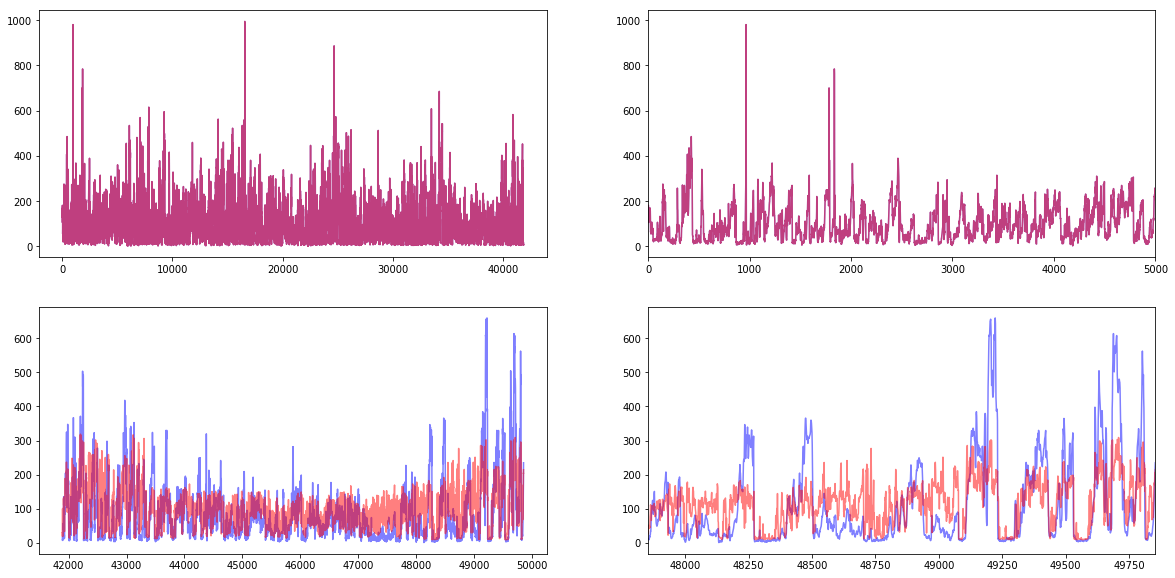

In [35]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### MLPRegressor model

In [36]:
# explore with MLPRegressor model using default parameters

mlpr_1 = Pipeline([('scaler', StandardScaler()),('mlpr',MLPRegressor())])
mlpr_1.fit(X_train, y_train)
y_pred_train = mlpr_1.predict(X_train)
y_pred_test = mlpr_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(mlpr_1.named_steps.mlpr.n_layers_, mlpr_1.named_steps.mlpr.loss_)

0.6045077500254608 0.4528597698500407
3224.682754250154 4529.094607843237
3 1614.6447996363179


In [37]:
# adding PCA as a preprocessing step to decorrelate features

mlpr_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('mlpr',MLPRegressor())])
mlpr_2.fit(X_train, y_train)
y_pred_train = mlpr_2.predict(X_train)
y_pred_test = mlpr_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(mlpr_2.named_steps.mlpr.n_layers_, mlpr_2.named_steps.mlpr.loss_)

0.5890728525905974 0.4309585387290278
3350.532622547265 4710.387706594396
3 1680.0646071308531


In [38]:
# grid search of parameters hidden_layer_sizes, activation to improve MLPRegressor model

parameters = {'mlpr__activation': ['identity','logistic','tanh','relu'],'mlpr__hidden_layer_sizes':[(100,),(100,20),(50,100),(50,100,20)]}
mlpr_cv = GridSearchCV(mlpr_2, parameters, scoring='r2',cv=3)
mlpr_cv.fit(X_train, y_train)
print(mlpr_cv.best_params_)
print(mlpr_cv.best_score_)

{'mlpr__activation': 'logistic', 'mlpr__hidden_layer_sizes': (100,)}
0.39300145905821937


In [40]:
# update model with best parameters

mlpr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('mlpr',MLPRegressor(hidden_layer_sizes=(100,), activation='logistic'))])
mlpr_3.fit(X_train, y_train)
y_pred_train = mlpr_3.predict(X_train)
y_pred_test = mlpr_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(mlpr_3.named_steps.mlpr.n_layers_, mlpr_3.named_steps.mlpr.loss_)

# add scores to the score table
score_table.loc['MLPRegressor',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.49563583739533656 0.4105955866762848
4112.379995101757 4878.947302946087
3 2058.7512991784447


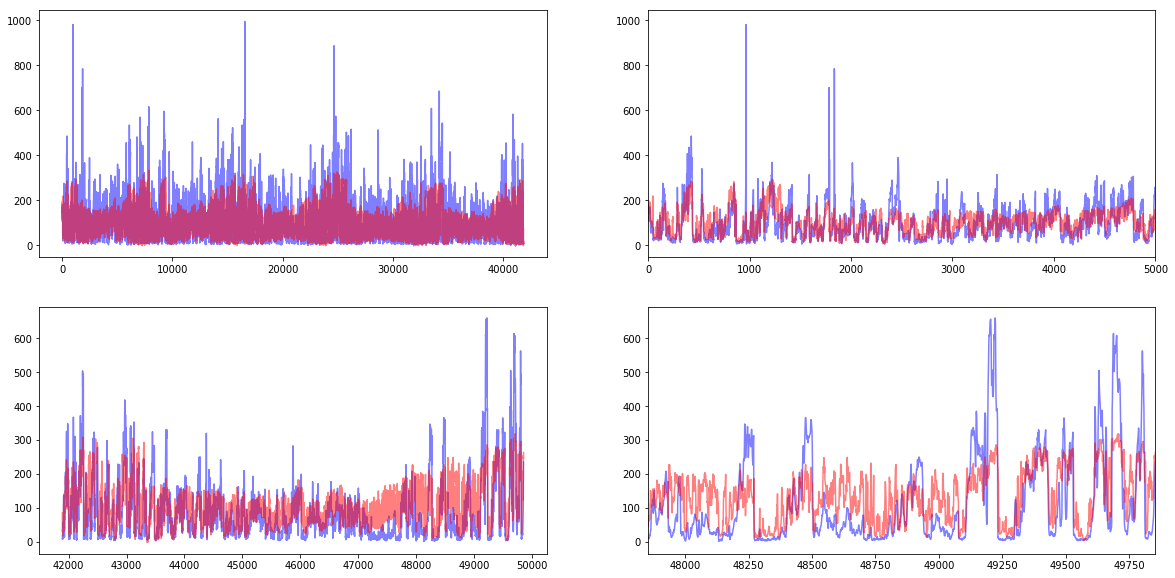

In [41]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

In [45]:
# output the summary table of scoring for different algorithms
print(score_table)

                           r2_train   r2_test   mse_train mse_test
LinearRegression           0.313779  0.272471     5595.17  6022.31
Lasso                      0.313001  0.268673     5601.51  6053.75
Ridge                      0.313245   0.27255     5599.52  6021.65
RandomForestRegressor      0.958717  0.436339     336.604  4665.85
GradientBoostingRegressor  0.517954  0.420768     3930.41  4794.74
KNeighborsRegressor               1  0.368429  1.2218e-21  5227.99
MLPRegressor               0.495636  0.410596     4112.38  4878.95
